In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/cs231a

/content/drive/MyDrive/cs231a


In [ ]:
!tar -xf val_infos.tar --wildcards "data/000027/000027.json" -C scene2
!tar -xf val_lidar.tar --wildcards "data/000027/lidar_roof/*.bin" -C scene2
!tar -xf val/val_cam01.tar --wildcards "data/000027/*/*.jpg" -C scene2
!tar -xf val/val_cam03.tar --wildcards "data/000027/*/*.jpg" -C scene2
!tar -xf val/val_cam05.tar --wildcards "data/000027/*/*.jpg" -C scene2
!tar -xf val/val_cam06.tar --wildcards "data/000027/*/*.jpg" -C scene2
!tar -xf val/val_cam07.tar --wildcards "data/000027/*/*.jpg" -C scene2
!tar -xf val/val_cam08.tar --wildcards "data/000027/*/*.jpg" -C scene2
!tar -xf val/val_cam09.tar --wildcards "data/000027/*/*.jpg" -C scene2

In [ ]:
!ls .

 000201_m4depth.pkl   pset4	    sfm.py	     'Untitled Diagram.drawio'
 000201.zip	      __pycache__   train	      val
 data		      sad.py	    train_infos.tar   val_infos.tar
 prediction2.pkl      Scene_fs.py   train_lidar.tar   val_lidar.tar
 prediction.pkl       Scene.py	    Untitled0.ipynb
 pset3		      scenes	    Untitled1.ipynb


In [ ]:
import pickle
with open('prediction.pkl', 'rb') as f:
  samples = pickle.load(f)

In [ ]:
samples.shape

(7, 2, 256, 768)

In [ ]:
from Scene import Scene
scene = Scene('/content/drive/MyDrive/cs231a', scene_id='000201')#000027

In [ ]:
samples.max(), samples.min()

(6354.4277, 1108.8756)

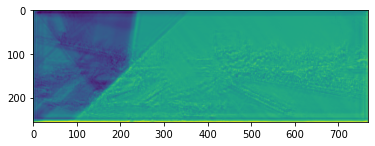

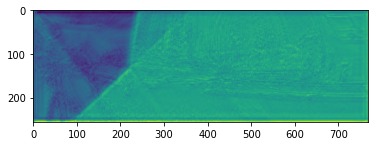

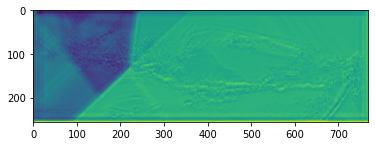

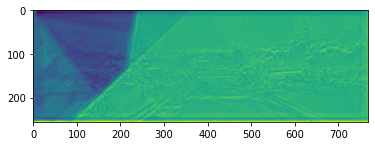

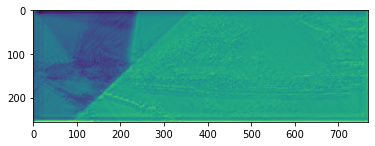

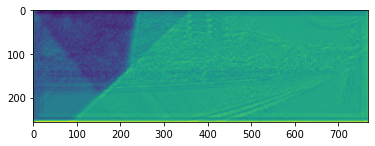

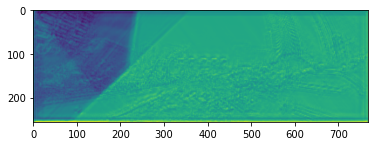

In [ ]:
images = samples[:, 0]
import matplotlib.pyplot as plt
for i in images:
  plt.figure()
  plt.imshow(i)

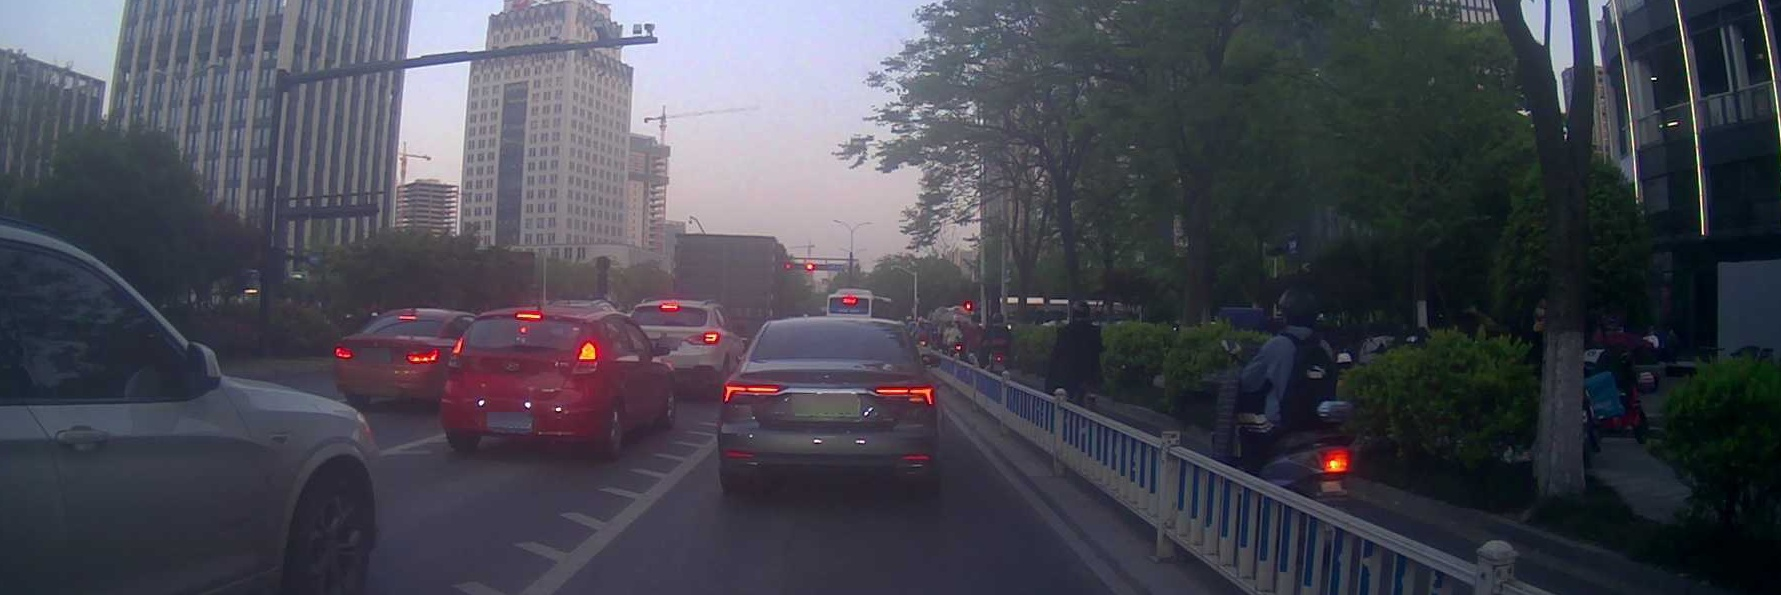

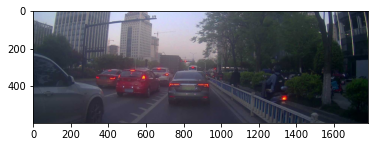

In [ ]:
frame = scene.get_cam_frame(frame_id=scene.frame_ids[0], cam_id=scene.cams[0])
import numpy as np
i = np.mgrid[int(0.20810811 * frame.shape[0]):int(0.79189189 * frame.shape[0]), int(0.03594771 * frame.shape[1]):int(0.96405229 * frame.shape[1])]
i = np.transpose(i, (1, 2, 0))
i = frame[i[..., 0], i[..., 1]]
import matplotlib.pyplot as plt
plt.imshow(i)
from IPython.display import Image
import cv2
_,ret = cv2.imencode('.jpg', i[..., ::-1]) 
Image(data=ret) 

In [ ]:
np.rad2deg(2 * np.arctan(1980 /2/ 9.588315e+02))

91.83255582842558

In [ ]:
crop = np.mgrid[int(0.20810811 * frame.shape[0]):int(0.79189189 * frame.shape[0]):256j, int(0.03594771 * frame.shape[1]):int(0.96405229 * frame.shape[1]):768j]
crop = np.transpose(crop, (1, 2, 0))
crop = np.concatenate([crop, np.ones(crop.shape[:2] + (1,))], -1)
crop = crop.reshape(-1, 3).T

import numpy as np

points = []
for frame_idx, frame_id in enumerate(scene.frame_ids[::4*200]):
  # if frame_idx % 10 != 0: continue
  for cam_idx, cam_id in enumerate(scene.cams[::4*200]):
    pose = scene.get_pose(frame_id=frame_id)
    camera_pose = scene.get_camera_pose(cam_id=cam_id, frame_id=frame_id)
    K = scene.get_k(cam_id=cam_id)
    R = pose[:3,:3]
    t = pose[:3,3]

    # print(samples[cam_idx, frame_idx].shape)
    depth = samples[cam_idx, frame_idx].reshape(-1, 1).T

    # points_2d = np.linalg.inv(K) @ crop
    # points_2d *= depth / 1000
    # points_3d = np.concatenate([points_2d, np.ones((1, points_2d.shape[1]))], 0)

    pose44 = np.concatenate([pose, [[0, 0, 0, 1]]], 0)

    # points_3d = np.linalg.inv(pose44) @ np.linalg.inv(camera_pose) @ points_3d
    # # points_3d = points_3d[:3] / points_3d[np.newaxis, 3]
    # # points_3d *= depth / 1000
    # print(points_3d)
    # # points.append(points_3d)

    # # print(K, K.shape)
    # # K34 = np.concatenate([K, np.array([[0, 0, 0]]).T], 1)
    # # print(K34, K34.shape)


    # points_3d = np.linalg.inv(K) @ crop
    # points_3d = np.concatenate([points_3d, np.ones((1, points_3d.shape[1]))], 0)
    # points_3d = np.linalg.inv(pose44) @ np.linalg.inv(camera_pose) @ points_3d
    # # print(points_3d.shape)
    # points_3d = points_3d[:3] / points_3d[np.newaxis, 3]
    # points_3d *= depth
    # points.append(points_3d)

    # # print(points_3d)
    # # break
  
    # # points_3d /= points_3d[:, 3, np.newaxis]

    # # points_3d = np.concatenate([points_3d, np.ones((1, points_3d.shape[1]))], 0)
    # # points_3d = camera_pose @ points_3d
    # # points_3d = points_3d[:3] / points_3d[3]
    # # points_3d = np.matmul(R, points_3d) + t.reshape(3,1)
    # # points_3d *= depth / 1000

    points_3d = np.linalg.inv(K) @ crop
    points_3d /= points_3d[np.newaxis, 2]
    points_3d *= depth / 1000
    #points_3d = np.array([[0, 0, 0]]).T
    points_3d = np.concatenate([points_3d, np.ones((1, points_3d.shape[1]))], 0)
    # points_3d = pose44 @ camera_pose @ points_3d
    # points_3d = points_3d[:3] / points_3d[np.newaxis, 3]

    # translate points to world frame
    camera_pose = scene.get_camera_pose(cam_id=cam_id, frame_id=frame_id)
    points_3d = camera_pose @ points_3d
    pose = scene.get_pose(frame_id=frame_id)
    R = pose[:3,:3]
    t = pose[:3,3]
    points_3d[:3] = np.matmul(R, points_3d[:3]) + t.reshape(3,1)
    print(camera_pose.shape, points_3d.shape)
    points_3d = points_3d[:3] / points_3d[np.newaxis, 3]
    # print(depth)
  
    points.append(points_3d)

point_cloud = np.concatenate(points, -1).T

(4, 4) (4, 196608)
(4, 4) (4, 196608)


In [ ]:
point_cloud

array([[ 1219.80533025, -1601.83312653,   755.74721743],
       [ 1219.7726983 , -1601.86635575,   751.86658178],
       [ 1233.87441146, -1620.45354997,   756.65607579],
       ...,
       [ 4069.50617417,  -206.03849582, -5498.94512588],
       [ 3894.8253674 ,  -198.94849538, -5275.49522075],
       [ 3894.95242469,  -198.7716016 , -5284.80014506]])

In [ ]:
print(point_cloud.shape)

(393216, 3)


In [ ]:
!ls

 000201_m4depth.pkl   __pycache__   train		       val
 000201.zip	      sad.py	    train_infos.tar	       val_infos.tar
 data		      Scene_fs.py   train_lidar.tar	       val_lidar.tar
 prediction2.pkl      Scene.py	    Untitled0.ipynb
 pset3		      scenes	    Untitled1.ipynb
 pset4		      sfm.py	   'Untitled Diagram.drawio'


In [ ]:
import numpy as np
subs = point_cloud[np.random.choice(point_cloud.shape[0], 1000000),:]
import pickle
with open('000027_m4depth.pkl', 'wb') as f:
  pickle.dump(subs, f)

In [ ]:
subs

array([[ 3564.84151737,  1117.66079915,  1448.6817432 ],
       [  241.58289698, -1625.45846878,  -785.58903574],
       [ 1059.02398313, -1660.64980675, -2010.00753698],
       ...,
       [ 1129.64894209, -1653.78421383, -1217.45887742],
       [  460.69221651, -1634.06639004,   -53.75564522],
       [ 3661.98949716,   647.65938855, -1094.9562817 ]])

<ipython-input-21-1359164a0a57>:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(lidar_points[:, 0], lidar_points[:, 1], lidar_points[:, 2], cmap='gray')


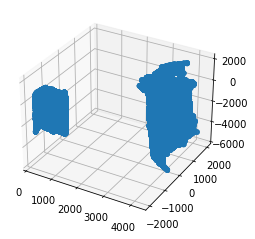

In [ ]:
import matplotlib.pyplot as plt

lidar_points = subs
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(lidar_points[:, 0], lidar_points[:, 1], lidar_points[:, 2], cmap='gray')

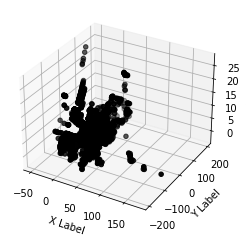

In [ ]:
import random
scene.plot_lidar_frame(random.choice(scene.frame_ids))